# ライブラリのインポート

In [1]:
# conda install xgboost
# conda install tqdm

In [39]:
import pandas as pd
import numpy as np
from tqdm import tqdm 

# 1. タスクと評価指標

In [40]:
# 学習データ、テストデータの読み込み
train = pd.read_csv('data/raw_data/train.csv')
test = pd.read_csv('data/raw_data/test.csv')

# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['Survived'], axis=1)
train_y = train['Survived']

# テストデータは特徴量のみなので、そのまま（元のデータはいじらないようにコピーを行う）
test_x = test.copy()

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [42]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [43]:
train.describe().columns.tolist()

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

<AxesSubplot:>

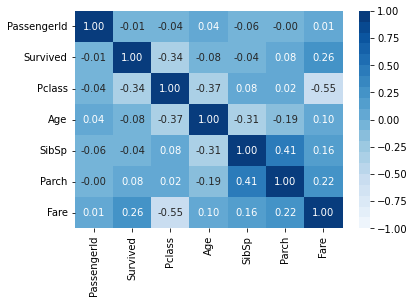

In [44]:
import seaborn as sns
cor = train[train.describe().columns.tolist()].corr()
# vmin および vmax 引数は、色軸のスケールを指定するために使用される。ここでの cmap 引数は、プロットに使用される配色を変更します。annot パラメーターは、正方形に相関値を表示するために使用される。
# sns.heatmap(cor, cmap= sns.color_palette('coolwarm', 10), annot=True, fmt='.2f', vmin = -1, vmax = 1)
sns.heatmap(cor, cmap= sns.color_palette('Blues', 20), annot=True, fmt='.2f', vmin = -1, vmax = 1)

In [45]:
train.describe(exclude='number')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


# 2. 特徴量の作成

In [46]:
from sklearn.preprocessing import LabelEncoder

# 変数 'PassengerId' を除外する（'PassengerId'はIDなので特徴量ではないため）
train_x.drop(['PassengerId'], axis=1, inplace=True)
test_x.drop(['PassengerId'], axis=1, inplace=True)

# 変数 'Name', 'Ticket', 'Cabin' を除外する（扱いが大変そうだから今回は除外）
train_x.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_x.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [47]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [48]:
# それぞれのカテゴリ変数に label encoding を適用する（比較的カテゴリ化が簡単な 'Sex', 'Embarked' のみダミー変数化を行う）

# ワンホットエンコーディング：列を増やすエンコーディング
# get_dummiesを用いても良いが、今回のような訓練データとテストデータがもともと分けられている場合においてはテストデータにはあって訓練データにはないデータがあるかもしれないので、訓練データで学習したダミー変数化を行う関数を用いることで対応している
# pandas.DataFrameの場合は、デフォルトではデータ型dtypeがobject（おもに文字列）またはcategoryである列がすべてダミー変数化される。
# dummy_na=True : デフォルトでは欠損値は除外して処理される（全ての項目が0になる）が、Trueにすると欠損値も一つのカテゴリーとしてダミー変数化される
# drop_first : k個のカテゴリーをk-1でダミー化する（多重共線性を回避するため）
#train_x = pd.get_dummies(train_x, dummy_na=True, drop_first=True)
#test_x = pd.get_dummies(test_x, dummy_na=True, drop_first=True) 

# ラベルエンコーディング：
# GBDTでは、文字列をそのまま入れてしまうとエラーとなってしまう
for c in ['Sex', 'Embarked']:

    # 学習データに基づいてどう変換するかを定める
    le = LabelEncoder()
    le.fit(train_x[c].fillna('NA')) #今回のモデルは XGBT なので欠損値があっても問題ない # fitの際に与えたカテゴリの要素の順番が番号の順番となる 例：S, C, Qで要素が出てくれば、S=0, C=1, Q=2の順になる

    # 学習データ、テストデータを変換する
    train_x[c] = le.transform(train_x[c].fillna('NA'))
    test_x[c] = le.transform(test_x[c].fillna('NA'))

# 順序に意味がない名義尺度では、LabelEncoderで変換される整数値を用いて回帰分析を行うことはできない。上の例で、label と sizeを使ってpriceを回帰分析で予測する場合、labelは1⇒2⇒0の順で大きくなるので、変数としてふさわしくない。
# LabelEncoderで1つの変数の離散値として扱う場合は、決定木分析、ランダムフォレストなどの分析と相性が良い。また、後述するダミー変数よりも変数の数を節約できる。



In [74]:
train_x['Embarked'].value_counts()

3    644
0    168
2     77
1      2
Name: Embarked, dtype: int64

In [81]:
# 出港地の数値化
train_pre = pd.DataFrame()

emb_mapping = {np.nan:0, 'S':1, 'C':2, 'Q':3}
train_pre['Embarked_map'] = train['Embarked'].map(emb_mapping)

town_le = LabelEncoder()
town_le.classes_ = [np.nan, 'S', 'C', 'Q']
train_pre['Embarked_classes'] = town_le.transform(train['Embarked'])

train_pre['Embarked_origin'] = train['Embarked']


In [82]:
train_pre.head(15)

,Embarked_map,Embarked_classes,Embarked_origin
0,1,1,S
1,2,2,C
2,1,1,S
3,1,1,S
4,1,1,S
5,3,3,Q
6,1,1,S
7,1,1,S
8,1,1,S
9,2,2,C


In [83]:
train_pre['Embarked_map'].value_counts()

1    644
2    168
3     77
0      2
Name: Embarked_map, dtype: int64

In [18]:
len(train[train['Embarked'].isnull()])

2

In [19]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [20]:
train_x['Embarked'].value_counts() # 1:欠損値, 2:Q, 3:S, 0:C

3    644
0    168
2     77
1      2
Name: Embarked, dtype: int64

In [21]:
train_x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,3
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,3
3,1,0,35.0,1,0,53.1000,3
4,3,1,35.0,0,0,8.0500,3
...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,3
887,1,0,19.0,0,0,30.0000,3
888,3,0,NaN,1,2,23.4500,3
889,1,1,26.0,0,0,30.0000,0


# 3. モデルの作成

In [12]:
from xgboost import XGBClassifier

# モデルの作成及び学習データを与えての学習
model = XGBClassifier(n_estimators=20, random_state=71)
model.fit(train_x, train_y)

[13:15:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=20, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=71,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
# テストデータの予測値を確率で出力する
pred = model.predict_proba(test_x)[:, 1] #predict_probaの一つ目の配列にはクラス0に、二つ目の配列にはクラス1に属する確率を表している

In [14]:
# テストデータの予測値を確率で出力する
pred_label = np.where(pred > 0.5, 1, 0) # 闘値の設定 = 0.5

In [15]:
pd.Series(pred_label).value_counts()

0    286
1    132
dtype: int64

In [16]:
print(model.score(train_x, train_y)) #決定係数：モデルの性能評価

0.9090909090909091


In [17]:
# 提出用ファイルの作成
submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':pred_label})
submission.to_csv('data/predict_data/submission_first.csv', index=False)

In [18]:
# 隔ったたデータでないかの確認、1よりも0が圧倒的に多い時などモデルが0と予測すれば大体当たると勘違いして0ばかりを予測してしまう現象がある。
# そのためダウンサンプリングを行う必要性についても検討する
pd.Series(train_y).value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [19]:
pred > 0.5 # bool値は False:0, True:1 とみなされる

array([False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False,  True,  True, False, False,
       False, False, False, False,  True,  True,  True, False,  True,
       False,  True, False, False, False,  True, False,  True, False,
       False, False, False,  True, False, False, False,  True,  True,
       False, False, False,  True,  True, False, False,  True,  True,
       False, False, False, False, False,  True, False, False, False,
        True,  True,  True,  True, False, False,  True, False, False,
       False, False,  True, False, False,  True, False, False,  True,
       False, False, False, False, False,  True, False,  True,  True,
       False, False,  True, False,  True, False,  True, False,  True,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
        True,  True,  True,  True, False,  True, False, False, False,
       False,  True,

# 4. モデルの評価

In [20]:
# クロスバリデーションの簡単なやり方
# from sklearn.model_selection import cross_val_score
# logreg = LogisticRegression()
# # 交差検証
# scores = cross_val_score(logreg, iris.data, iris.target, cv=3)
# # 各分割におけるスコア
# print('Cross-Validation scores: {}'.format(scores))
# # スコアの平均値
# import numpy as np
# print('Average score: {}'.format(np.mean(scores)))

#単純なクロスバリデーションと層化k分割交差検証（Stratified k-fold cross-validation）
# from sklearn.model_selection import KFold
# from sklearn.model_selection import StratifiedKFold
# # 単純な方法
# kfold = KFold(n_splits=3)
# print('Cross-validation scores: \n{}'.format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))
# # 層化 k 分割交差検証 : 各分割内でのクラスの比率が全体の比率と同じになるように分割する
# stratifiedkfold = StratifiedKFold(n_splits=3)
# print('Cross-validation scores: \n{}'.format(cross_val_score(logreg, iris.data, iris.target, cv=stratifiedkfold)))

from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 各foldのスコアを保存するリスト
scores_accuracy = []
scores_logloss = []

# クロスバリデーション
# 学習データを4つに分割し、うち1つをバリデーションデータとすることを、バリデーションデータを変えて繰り返す
# 単純なクロスバリデーション
# kf = KFold(n_splits=4, shuffle=True, random_state=71)
# for tr_idx, va_idx in kf.split(train_x, train_y):
# 層化クロスバリデーション
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_x, train_y):

    # 学習データを学習データとバリデーションに分ける
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    # モデルの学習を行う
    model = XGBClassifier(n_estimators=20, random_state=71)
    model.fit(tr_x, tr_y)

    # バリデーションデータの予測値を確率で出力する
    va_pred = model.predict_proba(va_x)[:, 1]

    # バリデーションデータでのスコアを計算する
    logloss = log_loss(va_y, va_pred)
    accuracy = accuracy_score(va_y, va_pred > 0.5)
    
    # その fold のスコアを保存する
    scores_logloss.append(logloss)
    scores_accuracy.append(accuracy)

# 各 fold のスコアの平均を出力する
logloss = np.mean(scores_logloss)
accuracy = np.mean(scores_accuracy)

print(f'logloss : {logloss:.4f}, accuracy : {accuracy:.4f}')

[13:15:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/

logloss : 0.4451, accuracy : 0.8160

# 5. モデルのチューニング

In [21]:
import itertools

# チューニング候補とするパラメータを準備する
param_space = {'max_depth':[3, 5, 7], 
               'min_child_weight':[1.0, 2.0, 4.0]}

# 探索するハイパーパラメータの組み合わせ
param_combinations = itertools.product(
    param_space['max_depth'], param_space['min_child_weight'])

# 各パラメータの組み合わせ、それに対するスコアを保存するリスト
params = []
scores = []
accuracy_list = []

# 各パラメータの組み合わせごとに、クロスバリデーションで評価を行う
for max_depth, min_child_weight in param_combinations:

    score_folds = []
    accuracy_folds = []
    # クロスバリデーションを行う
    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=71)
    for tr_idx, va_idx in kf.split(train_x, train_y):
        
        # 学習データを学習データとバリデーションに分ける
        # command + shift + → : 選択文字以降の全選択
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

        # モデルの学習
        # n_estimations : epochs と同様、xgboostでは決定木の数を指定している
        model = XGBClassifier(
            n_estimators=20, random_state=71, max_depth=max_depth,
            min_child_weight=min_child_weight)
        model.fit(tr_x, tr_y)

        # バリデーションデータのスコアを計算し、保存する
        va_pred = model.predict_proba(va_x)[:, 1]
        logloss = log_loss(va_y, va_pred) # logless:低い方が良い指標
        score_folds.append(logloss)
        accuracy = accuracy_score(va_y, va_pred > 0.5)
        accuracy_folds.append(accuracy)


    # 各foldのスコアを平均する
    score_mean = np.mean(score_folds)
    accuracy_mean = np.mean(accuracy_folds)

    # パラメータの組み合わせ、それに対するスコアを保存する
    params.append((max_depth, min_child_weight))
    scores.append(score_mean)
    accuracy_list.append(accuracy_mean)

# 最もスコアが良いものをベストなパラメータとする
#numpy.argsort():値ではなく並び替えたインデックス（元のndarrayでの位置 = 0始まりの順番）のndarrayを返す。
best_idx = np.argsort(scores)[0] 
best_param = params[best_idx]
print(f'max_depth: {best_param[0]}, min_child_weight: {best_param[1]}')



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/

[13:16:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/

[13:16:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/

max_depth: 3, min_child_weight: 2.0 のスコアが最も良かった

In [22]:
pd.DataFrame({'params': params, 'scores': scores, 'accuracy': accuracy_list}).sort_values('scores')

,params,scores,accuracy
1,"(3, 2.0)",0.418608,0.817088
2,"(3, 4.0)",0.421926,0.824920
0,"(3, 1.0)",0.422372,0.812598
5,"(5, 4.0)",0.423098,0.819330
8,"(7, 4.0)",0.430602,0.826077
4,"(5, 2.0)",0.431798,0.817098
3,"(5, 1.0)",0.434621,0.818224
7,"(7, 2.0)",0.440934,0.823819
6,"(7, 1.0)",0.455552,0.819335


In [26]:
from sklearn.model_selection import GridSearchCV

# グリッドサーチによるハイパーパラメータ探索候補設定
# 今回はRandomForestClassifierのパラメータが対象(値は任意に設定)
parameters = {'max_depth':[3, 5, 7], 
              'min_child_weight':[1.0, 2.0, 4.0]}

# モデルインスタンス
model = XGBClassifier(
            n_estimators=20, random_state=71)

# クロスバリデーションインスタンス
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=71)

# ハイパーパラメータチューニング(グリッドサーチのコンストラクタにモデルと辞書パラメータを指定)
gridsearch = GridSearchCV(estimator = model,        # モデル
                          param_grid = parameters,  # チューニングするハイパーパラメータ
                          scoring = "neg_log_loss", # スコアリング
                          cv = kf) # クロスバリデーション用オブジェクト


# 演算実行
gridsearch.fit(train_x, train_y)

# グリッドサーチの結果から得られた最適なパラメータ候補を確認
print('Best params: {}'.format(gridsearch.best_params_)) 
print('Best Score: {}'.format(gridsearch.best_score_))

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/

[13:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/

[13:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/

[13:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best params: {'max_depth': 3, 'min_child_weight': 2.0}  
Best Score: -0.41860814517734435

### ハイパーパラメータをチューニングしたモデル

In [153]:
# max_depth: 3, min_child_weight: 2.0

# 各foldのスコアを保存するリスト
scores_accuracy = []
scores_logloss = []

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_x, train_y):

    # 学習データを学習データとバリデーションに分ける
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    # モデルの学習を行う
    model = XGBClassifier(n_estimators=20, random_state=71, max_depth=3, min_child_weight=2.0)
    model.fit(tr_x, tr_y)

    # バリデーションデータの予測値を確率で出力する
    va_pred = model.predict_proba(va_x)[:, 1]

    # バリデーションデータでのスコアを計算する
    logloss = log_loss(va_y, va_pred)
    accuracy = accuracy_score(va_y, va_pred > 0.5)
    
    # その fold のスコアを保存する
    scores_logloss.append(logloss)
    scores_accuracy.append(accuracy)

# 各 fold のスコアの平均を出力する
logloss = np.mean(scores_logloss)
accuracy = np.mean(scores_accuracy)

print(f'logloss : {logloss:.4f}, accuracy : {accuracy:.4f}')

/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


logloss : 0.4186, accuracy : 0.8171

In [154]:
pred = model.predict_proba(test_x)[:, 1]
pred_label = np.where(pred > 0.5, 1, 0)

In [155]:
# 提出用ファイルの作成
submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':pred_label})
submission.to_csv('data/predict_data/xgboost_md3mcw2_submission.csv', index=False)

# 6. アンサンブル
 xgboost と LogisticRegression のアンサンブル（xgboostの方が精度が高いことから、xgboostに大きい重みをつけた加重平均をとることとする）

In [139]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [140]:
train_x2 = train.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
test_x2 = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [141]:
train_x2 = pd.get_dummies(train_x2, drop_first=True)
test_x2 = pd.get_dummies(test_x2, drop_first=True)

In [142]:
pd.DataFrame({'train_x2':train_x2.isnull().sum(), 'test_x2':test_x2.isnull().sum()}) # 欠損値の確認

,train_x2,test_x2
Pclass,0,0
Age,177,86
SibSp,0,0
Parch,0,0
Fare,0,1
Sex_male,0,0
Embarked_Q,0,0
Embarked_S,0,0


In [143]:
train_x2['Age'].fillna(train_x2['Age'].median(), inplace=True)
test_x2.fillna(test_x2.median(), inplace=True)

In [152]:
# ロジスティック回帰のみの予測

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold

# 各foldのスコアを保存するリスト
scores_accuracy = []
scores_logloss = []

# クロスバリデーション
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_x2, train_y):

    # 学習データを学習データとバリデーションに分ける
    tr_x2, va_x2 = train_x2.iloc[tr_idx], train_x2.iloc[va_idx]
    tr_y2, va_y2 = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    # LogisticRegression
    # xgboostモデルとは異なる特徴量をいれる必要があるので、別途 train_x2, test_x2 を上記で作成
    model_lr = LogisticRegression(solver='lbfgs', max_iter=300) #ロジスティック回帰はデフォルトで q=2 の正則化項が損失関数に含まれている
    model_lr.fit(tr_x2, tr_y2)
    va_pred = model_lr.predict_proba(va_x2)[:, 1]
    pred_label = np.where(pred > 0.5, 1, 0)

    # バリデーションデータでのスコアを計算する
    logloss = log_loss(va_y2, va_pred)
    accuracy = accuracy_score(va_y2, va_pred > 0.5)
    
    # その fold のスコアを保存する
    scores_logloss.append(logloss)
    scores_accuracy.append(accuracy)

# 各 fold のスコアの平均を出力する
logloss = np.mean(scores_logloss)
accuracy = np.mean(scores_accuracy)

print(f'logloss : {logloss:.4f}, accuracy : {accuracy:.4f}')

logloss : 0.4521, accuracy : 0.7969


In [151]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold

# 各foldのスコアを保存するリスト
scores_accuracy = []
scores_logloss = []

# クロスバリデーション
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_x2, train_y):

    # 学習データを学習データとバリデーションに分ける
    tr_x2, va_x2 = train_x2.iloc[tr_idx], train_x2.iloc[va_idx]
    tr_y2, va_y2 = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    # xgboost
    model_xgb = XGBClassifier(n_estimators=20, random_state=71) # max_depth=3, min_child_weight=2.0 → logloss : 0.4200, accuracy : 0.8182
    model_xgb.fit(tr_x2, tr_y2)
    pred_xgb = model_xgb.predict_proba(va_x2)[:, 1]

    # LogisticRegression
    # xgboostモデルとは異なる特徴量をいれる必要があるので、別途 train_x2, test_x2 を上記で作成
    model_lr = LogisticRegression(solver='lbfgs', max_iter=300)
    model_lr.fit(tr_x2, tr_y2)
    pred_lr = model_lr.predict_proba(va_x2)[:, 1]

    # 予測値の加重平均をとる
    va_pred = pred_xgb * 0.8 + pred_lr * 0.2 # pred_xgbが0.7の時点で0.56とかなりxgbに重みをつけている
    pred_label = np.where(pred > 0.5, 1, 0) # pred_xgbが0.6の時0.48なので、pred_lrが0.1であれば0.5となりpred_labelはギリギリ0の値になる

    # バリデーションデータでのスコアを計算する
    logloss = log_loss(va_y2, va_pred)
    accuracy = accuracy_score(va_y2, va_pred > 0.5)
    
    # その fold のスコアを保存する
    scores_logloss.append(logloss)
    scores_accuracy.append(accuracy)

# 各 fold のスコアの平均を出力する
logloss = np.mean(scores_logloss)
accuracy = np.mean(scores_accuracy)

print(f'logloss : {logloss:.4f}, accuracy : {accuracy:.4f}')


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:50:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:50:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:50:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:50:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
logloss : 0.4200, accuracy : 0.8182


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


logloss : 0.4264, accuracy : 0.8283